In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("../")

import gurobipy
#import gurobi901 as gurobipy
from json import dumps, loads
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression as skLogisticRegression
from sklearn.metrics import (classification_report, f1_score, precision_score, recall_score)
from tqdm import tnrange, trange
import tensorflow as tf

from mlsql import InfluenceRanker, SelfLossInfluenceRanker, AutoFixer, ModelManager, LossRanker, TiresiasRanker, multi_ambiguity_count
from mlsql.models import SimpleCNN, LogReg
from mlsql.utils import setdiff1d
# from processors.mnist import (MNISTCountAggregationComplaintProcessor, MNISTJoinAggregationProcessor, MNISTJoinRowsProcessor,
#                               MNISTJoinAmbiguityProcessor, MNISTGroupbyCountProcessor, MNISTCountPointComplaintProcessor, 
#                              MNISTCountWrongComplaintProcessor, MNISTCountAggregationComplaintShortEyeSightProcessor)
# from processors.enron import ENRONProcessor
# from processors.dblp import DBLPProcessor
# from processors.adult import AdultProcessor
# import processors.adultNoCorr
from processors.compas import CompasProcessor

from itertools import groupby
from functools import partial

import logging
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)

In [2]:
rank_res=[]

@tf.function
def rank_fix(ranker):
    rank = ranker.predict()
#     tf.stack(rank)
#     tf.print("rank",rank)
    fixer.fix(rank)

@tf.function
def train(manager):
    manager.fit()

In [3]:
seed = 2987429

In [4]:
proc = CompasProcessor(
    seed, 
    corruption_rate=0,
    complaint_mode="",
   
#     partition=partition
#     corruption_type="positive",
#     corruption_rate=corruption_rate
#     complaint_percent=complaint_percent,
#     complaint_mode=complaint_mode,
#     direct_rate = direct_rate,
)

# proc = ENRONProcessor(seed, "http", sparse=False)
# Xcorr, ycorr, corrsel = proc.get_corrupted()
Xclean, yclean = proc.get_clean() 
print(proc.ytrain.shape)

19
18
(4937, 2)


In [7]:
manager = ModelManager(proc.Xtrain, proc.ytrain, LogReg(proc, 2))
manager.fit()
print("LogReg")
print("On Training Clean\n", classification_report(tf.argmax(proc.ytrain, axis=1).numpy(), manager.predict(proc.Xtrain).numpy()))
print("On Testing\n", classification_report(tf.argmax(proc.y_test_full, axis=1).numpy(), manager.predict(proc.X_test_full).numpy()))

LogReg
On Training Clean
               precision    recall  f1-score   support

           0       0.68      0.73      0.70      2680
           1       0.65      0.59      0.62      2257

    accuracy                           0.67      4937
   macro avg       0.66      0.66      0.66      4937
weighted avg       0.67      0.67      0.67      4937

On Testing
               precision    recall  f1-score   support

           0       0.71      0.76      0.73       683
           1       0.67      0.61      0.64       552

    accuracy                           0.69      1235
   macro avg       0.69      0.69      0.69      1235
weighted avg       0.69      0.69      0.69      1235



In [5]:
step_size = 10
exp_results = {}
corrsel = tf.cast(tf.ones(yclean.shape[0]), dtype='bool')

Rankers = [
    partial(InfluenceRanker, on=proc.complain),
#     SelfLossInfluenceRanker
#     LossRanker
#     partial(TiresiasRanker, proc=proc, batch_size=64)
]

for Ranker in Rankers:
#     manager = ModelManager(Xcorr, ycorr, SimpleCNN(proc, ycorr.shape[1], (28, 28, 1)))
    manager = ModelManager(proc.Xtrain, proc.ytrain, LogReg(proc, proc.ytrain.shape[1]))
    manager.fit()
#     ambiguity = proc.ambiguity(manager)
    proc.post_init(manager)
#     AC, AQ, PC, PQ = None, None, None, None
    AC, AQ, PC, PQ = proc.complain(manager)
    
#    K = min(int(corrsel.numpy().sum() * 1), len(Xcorr))
    K = 400
     
    fixer = AutoFixer(manager, yclean, corrsel, K)
    ranker = Ranker(manager=manager)
    
    ACs = None
    AQs = None
    PCs = None
    PQs = None
    
    if AC is not None:
        ACs = np.empty((K, *AC.shape))
        ACs_exact = np.empty((K, *AC.shape))
    if AQ is not None:
        AQs = np.empty((K, *AQ.shape))
        AQs_exact = np.empty((K, *AQ.shape))
    if PC is not None:
        PCs = np.empty((K, *PC.shape))
        PCs_exact = np.empty((K, *PC.shape))
    if PQ is not None:
        PQs = np.empty((K, *PQ.shape))
        PQs_exact = np.empty((K, *PQ.shape))
    
    for k in tnrange(0, K, step_size, desc=ranker.name()):
        now = time()
        train(manager)
        for i in range(step_size):
            if i + k >= K:
                break
            rank_fix(ranker)
            AC, AQ, PC, PQ = proc.complain(manager)
            if AC is not None:
                ACs_exact[k + i] = AC
            if AQ is not None:
                AQs_exact[k + i] = AQ
            if PC is not None:
                PCs_exact[k + i] = PC
            if PQ is not None:
                PQs_exact[k + i] = PQ
            AC, AQ, PC, PQ = proc.complain(manager, exact=False)
            if AC is not None:
                ACs[k + i] = AC
            if AQ is not None:
                AQs[k + i] = AQ
            if PC is not None:
                PCs[k + i] = PC
            if PQ is not None:
                PQs[k + i] = PQ
        
    
    exp_results[ranker.name()] = (manager, ranker, _, _, _, _)
    

start



In [26]:
AQs


array([[0.10937387],
       [0.10937387],
       [0.10937387],
       [0.10937387],
       [0.10937387],
       [0.10937387],
       [0.10937387],
       [0.10937387],
       [0.10937387],
       [0.10937387],
       [0.11290443],
       [0.11290443],
       [0.11290443],
       [0.11290443],
       [0.11290443],
       [0.11290443],
       [0.11290443],
       [0.11290443],
       [0.11290443],
       [0.11290443],
       [0.11519635],
       [0.11519635],
       [0.11519635],
       [0.11519635],
       [0.11519635],
       [0.11519635],
       [0.11519635],
       [0.11519635],
       [0.11519635],
       [0.11519635],
       [0.12021011],
       [0.12021011],
       [0.12021011],
       [0.12021011],
       [0.12021011],
       [0.12021011],
       [0.12021011],
       [0.12021011],
       [0.12021011],
       [0.12021011],
       [0.1218245 ],
       [0.1218245 ],
       [0.1218245 ],
       [0.1218245 ],
       [0.1218245 ],
       [0.1218245 ],
       [0.1218245 ],
       [0.121

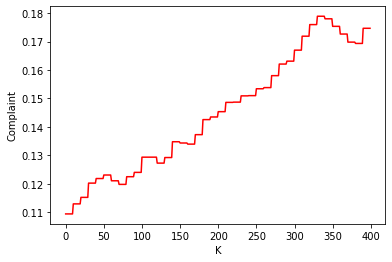

In [27]:
import numpy
plt.plot(np.arange(K), AQs, 'r')
plt.xlabel("K")
plt.ylabel("Complaint")
# plt.title("Margin of male average and female average")
plt.show()

In [6]:
from sklearn.metrics import accuracy_score

y_predict = tf.one_hot(manager.predict(proc.X_test_full), 2)

print(y_predict)
print(proc.y_test_full.shape)
target_names = ['class 0', 'class 1']
print(classification_report(proc.y_test_full, y_predict, target_names=target_names))

tf.Tensor(
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]], shape=(1235, 2), dtype=float32)
(1235, 2)
              precision    recall  f1-score   support

     class 0       0.72      0.65      0.69       683
     class 1       0.62      0.69      0.65       552

   micro avg       0.67      0.67      0.67      1235
   macro avg       0.67      0.67      0.67      1235
weighted avg       0.67      0.67      0.67      1235
 samples avg       0.67      0.67      0.67      1235

